# IEEE ICME 2024 GRAND CHALLENGE - Semi-supervised Acoustic Scene Classification under Domain Shift
## NAME OF SUBMISSION 
Michael Neri and Marco Carli

Roma Tre University, Department of Industrial, Electronic, and Mechanical Engineering



# Instructions
The structure of the project should be like the following:
- 📁 dev
    - 🎧 40c8570776704268be56bc0d1fa8a16f60_1.wav
    - 🎧 (...).wav (all other audio recordings of the development dataset)
- 📁 eval
    - 🎧 00b514a3c774405fb4005ea8c40d053e50_1.wav
    - 🎧 (...).wav (all other audio recordings of the evaluation dataset)
- 📁 TUT 2020 UAS 
    - 📁 audio
    - 🔢 meta.csv
- 📄 data.py (Dataset & Dataloaders)
- 📄 model.py (proposed approach)
- 📄 mobilenet.py (MobileFaceNet classifiers)
- 📄 utils.py 
- 📓 submission.ipynb (this file)
- 🔢 ICME2024_ASC_dev_label.csv
- 🔢 ICME2024_ASC_eval.csv
- 🧠 pretrained_TAU_pp5g.ckpt (weights after TAU pretraining)
- 🧠 pretrained_GC_hl19.ckpt (weights after multi-iteration FT process)
- 🧠 pretrained_GC_final_o2c4.ckpt (final weights after FT with unlabelled data)


# IMPORT PACKAGES AND CONSTANTS

To run all the sections, it is necessary to install the missing dependencies in Google Colab.

In [1]:
%pip install lightning
%pip install torchinfo
%pip install wandb
%pip install separableconv-torch

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


If the boolean variable `is_train` is `False`, the training and fine-tuning procedures will be skipped and pre-trained weights will be used. 

**N.B**.: the training code uses Weights&Biases for logging (https://wandb.ai).


If the boolean variable `to_plot` is `False`, no plots will be shown.

In [2]:
is_train = False # False = Use of pretrained models; True = Train on all the datasets
to_plot = True # False = no plots;

In [3]:
%matplotlib inline
from data import ICME2024Datamodule, TUT2020Datamodule
from model import Wavegram_AttentionMap
import pandas as pd
from sklearn.model_selection import train_test_split
from lightning import Trainer
from pytorch_lightning.loggers import WandbLogger
import wandb
from utils import ArcMarginProduct
import matplotlib.pyplot as plt
from data import LABELS_GC, LABELS_TUT
import torch
from sklearn.metrics import ConfusionMatrixDisplay
import librosa as lb
from os.path import join
from tqdm import tqdm
import IPython
import numpy as np

if to_plot:
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams['font.size'] = 10
    plt.rcParams['text.usetex'] = True
    plt.rcParams['figure.dpi'] = 200

## DATASET PREPARATION

In [4]:
path_csv = "ICME2024_ASC_dev_label.csv"
path_audios = "dev"
random_seed = 200 # for reproducibility of dataset split
print("All files: {}".format(pd.read_csv(path_csv).shape))

## READING STRONG LABELS AND SPLITTING
# if the label is not available, pandas inserts NaN
strong_files = pd.read_csv(path_csv).dropna(ignore_index = True).assign(confidence = 1)

# split in 80-10-10
trainingSet, testSet = train_test_split(strong_files, test_size=0.1, random_state = random_seed)
trainingSet, valSet = train_test_split(trainingSet, test_size=0.1, random_state = random_seed)
print("***Strong labels split***")
print("Train shape: {}".format(trainingSet.shape))
print("Val shape: {}".format(valSet.shape))
print("Test shape: {}".format(testSet.shape))

## READING NON-LABELLED DATA
unlabelled_files = pd.read_csv(path_csv).assign(confidence = 0)
unlabelled_files = unlabelled_files.drop(unlabelled_files.dropna().index)
print("Unlabelled shape: {}".format(unlabelled_files.shape))

All files: (8700, 2)
***Strong labels split***
Train shape: (1409, 3)
Val shape: (157, 3)
Test shape: (174, 3)
Unlabelled shape: (6960, 3)


# PRETRAINING ON TUT 2020 MOBILE DEVELOPMENT DATASET

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\Comlab\anaconda3\envs\deeplearning\lib\site-packages\lightning\pytorch\trainer\connectors\logger_connector\logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_flo

Testing DataLoader 0: 100%|██████████| 93/93 [00:15<00:00,  6.12it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test/acc            0.44811320304870605
     test/loss_class         2.867852210998535
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


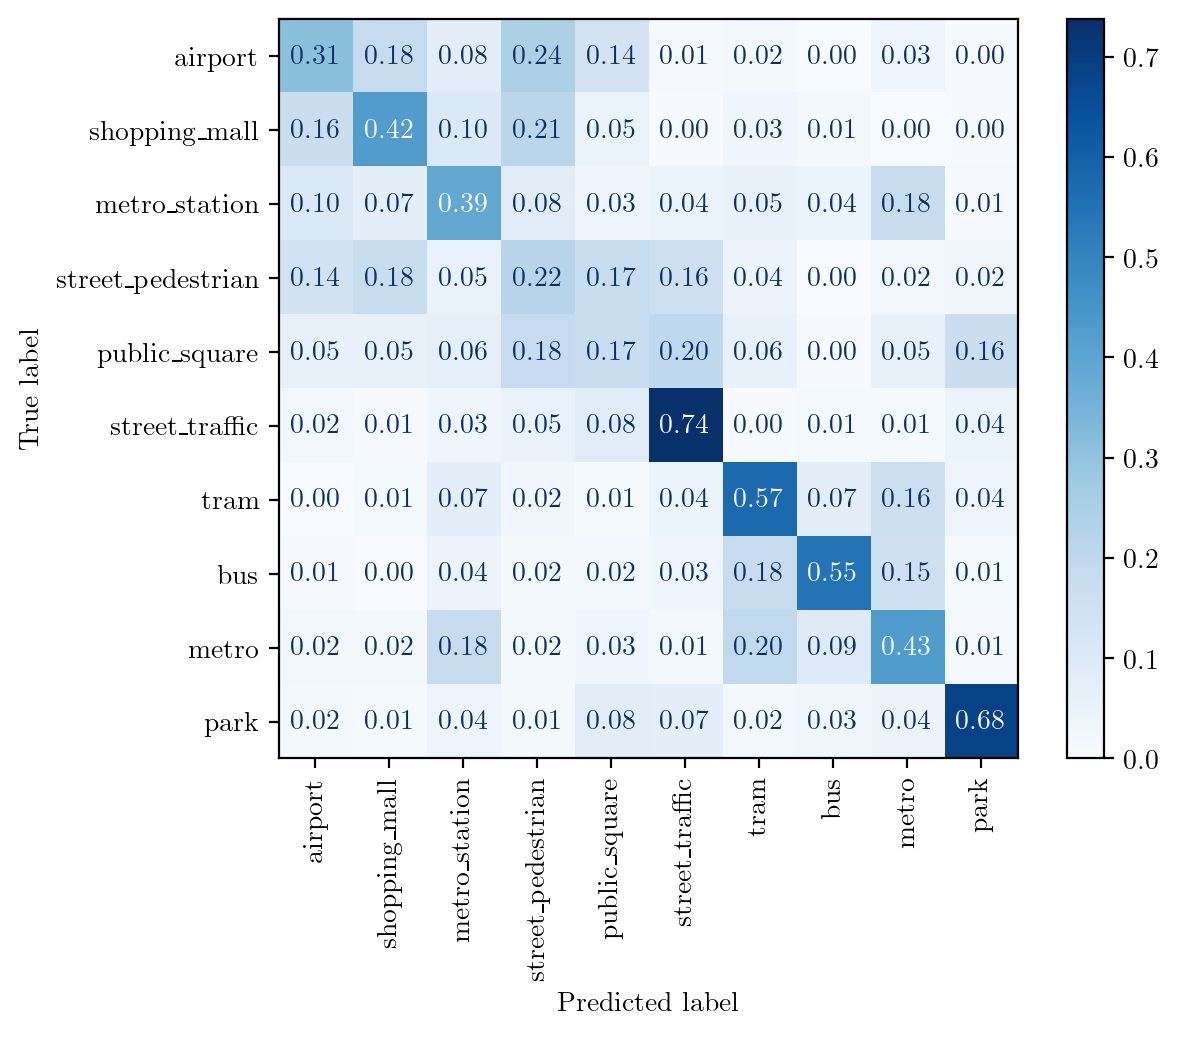

In [5]:
path_csv_training = "TUT 2020 UAS/evaluation_setup/fold1_train.csv"
path_csv_eval = "TUT 2020 UAS/evaluation_setup/fold1_evaluate.csv"
path_csv_test = "TUT 2020 UAS/evaluation_setup/fold1_test.csv"
training_pd = pd.read_csv(path_csv_training, delimiter="\t").assign(confidence = 1)
val_pd = pd.read_csv(path_csv_eval, delimiter="\t").assign(confidence = 1)
test_pd = pd.read_csv(path_csv_test, delimiter="\t").assign(confidence = 1)
datamodule = TUT2020Datamodule(training_pd, val_pd, test_pd, batch_size = 32) 
if is_train:
    model = Wavegram_AttentionMap(lr = 0.001)
    wandb_logger = WandbLogger(project="ICME2024Challenge", name="WavegramAttention m = 0.2 s = 8 no mixup ", tags = ["TUT2020", "pretraining"])
    trainer = Trainer(accelerator="gpu", devices = 1 , max_epochs = 100, logger=wandb_logger)
    trainer.fit(model, datamodule)
    trainer.test(model, datamodule)
    if to_plot:
        confusion_matrix = model.conf_mat.compute()
        confusion_matrix = confusion_matrix / (torch.sum(confusion_matrix, 1).unsqueeze(1))
        disp = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix.numpy(), display_labels = LABELS_TUT)
        disp.plot(cmap = "Blues", xticks_rotation = "vertical", values_format = '.2f')
        plt.savefig("CM_TUT.pdf", transparent = True, bbox_inches='tight')
    wandb.finish()
else:
    model = Wavegram_AttentionMap.load_from_checkpoint(checkpoint_path="pretrained_TAU_pp5g.ckpt", lr = 0.001)
    trainer = Trainer(accelerator="gpu", devices = 1 , max_epochs = 100)
    trainer.test(model, datamodule)
    if to_plot:
        confusion_matrix = model.conf_mat.compute()
        confusion_matrix = confusion_matrix / (torch.sum(confusion_matrix, 1).unsqueeze(1))
        disp = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix.numpy(), display_labels = LABELS_TUT)
        disp.plot(cmap = "Blues", xticks_rotation = "vertical", values_format = '.2f')
        plt.savefig("CM_TUT.pdf", transparent = True, bbox_inches='tight')

# STRONG LABELS TRAINING and TEST

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\Comlab\anaconda3\envs\deeplearning\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 3/3 [00:00<00:00,  4.69it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test/acc            0.9942528605461121
     test/loss_class       0.035694655030965805
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


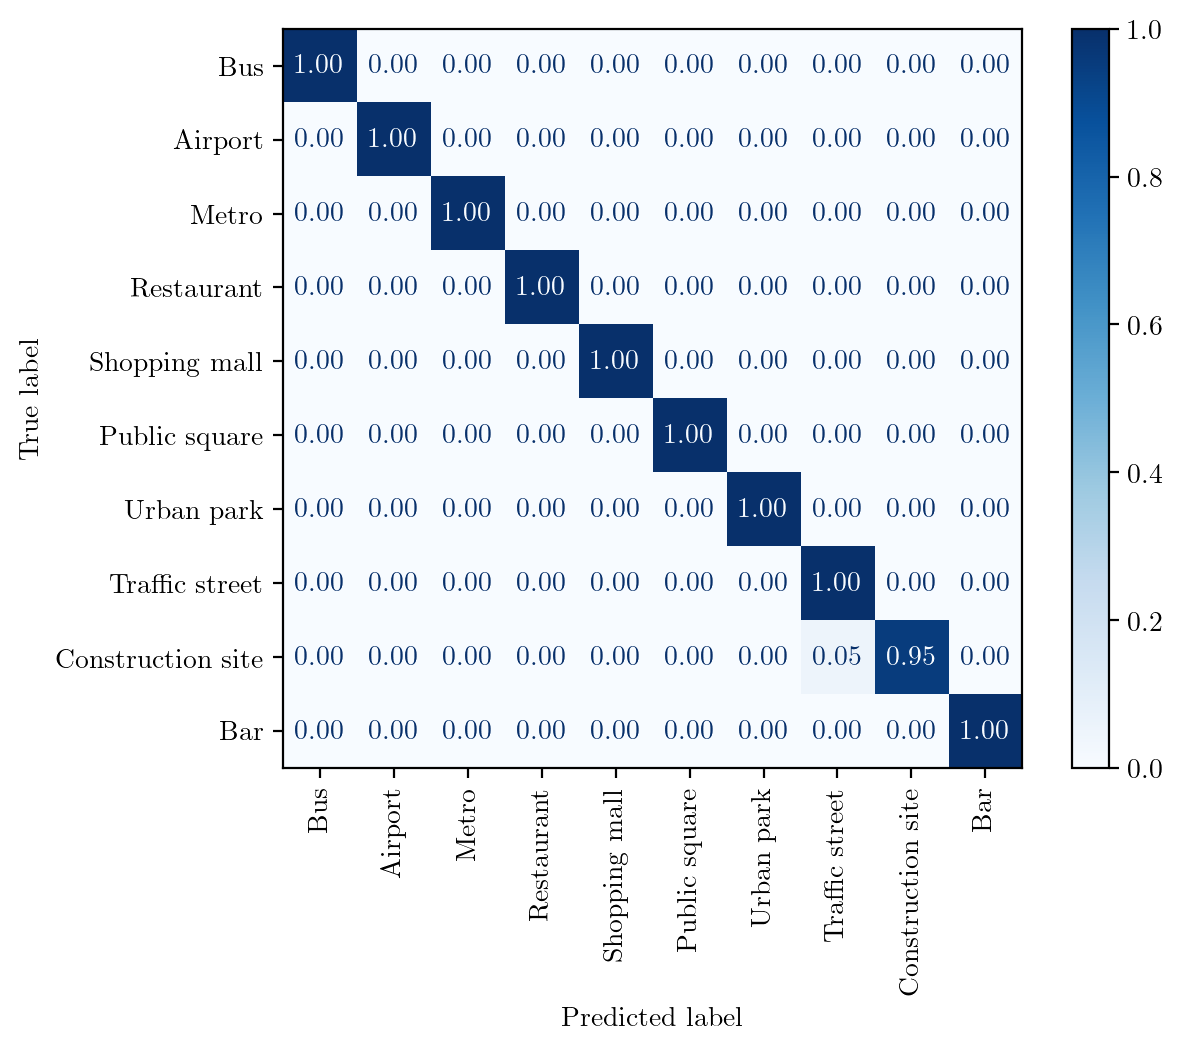

In [6]:
datamodule = ICME2024Datamodule(trainingSet, valSet, testSet, path_audios = path_audios, batch_size = 64)
if is_train:
    model = Wavegram_AttentionMap.load_from_checkpoint(checkpoint_path = "pretrained_TAU_pp5g.ckpt", lr = 0.001)
    for i in range(3): # three finetuning process
        wandb_logger = WandbLogger(project="ICME2024Challenge", name="WavegramAttention m = 0.2 s = 8 no mixup", tags = ["ICMEGCDataset", "onlyStrong"])
        trainer = Trainer(accelerator="gpu", devices = 1 , max_epochs = 100, logger = wandb_logger)
        model.model.arcface = ArcMarginProduct(in_features = 128, out_features = 10, s = 8, m = 0.2)
        trainer.fit(model, datamodule)
        trainer.test(model, datamodule)
        if to_plot:
                confusion_matrix = model.conf_mat.compute()
                confusion_matrix = confusion_matrix / (torch.sum(confusion_matrix, 1).unsqueeze(1))
                disp = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix.numpy(), display_labels = LABELS_GC)
                disp.plot(cmap = "Blues", xticks_rotation = "vertical", values_format = '.2f')
                plt.savefig("CM_intermediate.pdf", transparent = True, bbox_inches='tight')
        wandb.finish()
else:
    model = Wavegram_AttentionMap.load_from_checkpoint(checkpoint_path = "pretrained_GC_hl19.ckpt", lr = 0.001)
    trainer = Trainer(accelerator="gpu", devices = 1 , max_epochs = 100)
    trainer.test(model, datamodule)
    if to_plot:
        confusion_matrix = model.conf_mat.compute()
        confusion_matrix = confusion_matrix / (torch.sum(confusion_matrix, 1).unsqueeze(1))
        disp = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix.numpy(), display_labels = LABELS_GC)
        disp.plot(cmap = "Blues", xticks_rotation = "vertical", values_format = '.2f')
        plt.savefig("CM_intermediate.pdf", transparent = True, bbox_inches='tight')

# INFERENCE ON NON-LABELLED RECORDINGS

In [7]:
# example of one inference step
model = Wavegram_AttentionMap.load_from_checkpoint(checkpoint_path = "pretrained_GC_hl19.ckpt", lr = 0.001)
model = model.eval()
random_index = np.random.randint(low = 0, high = unlabelled_files.shape[0])
with torch.no_grad():
    filename = unlabelled_files.iloc[random_index, 0] + ".wav"
    print(filename)
    audio, sr = lb.load(join(path_audios, filename), mono = True, sr = 16000)    
    audio = torch.tensor(audio, dtype = torch.float, device = model.device).unsqueeze(0)
    # print(audio.shape)
    predicted, _, _, _ = model(audio, None)
    print(predicted)
    confidence = torch.softmax(predicted, 1)
    print(confidence)
    label_int = torch.argmax(confidence, 1).squeeze().cpu().numpy()
    print(label_int)
    string_label = LABELS_GC[label_int]
    print(string_label)
    confidence = confidence.cpu().squeeze().numpy()
    single_confidence = confidence[label_int]
    print(single_confidence)

IPython.display.Audio(join(path_audios, filename), rate = 16000)

# unlabelled_files is the variable containing filename , empty label , confidence = 0
with torch.no_grad():
    for i in tqdm(range(unlabelled_files.shape[0])): # for each file, we fed to the trained model to obtain soft labels
        # same process as a __getitem__ of a pytorch Dataset
        filename_raw = unlabelled_files.iloc[i, 0] 
        filename = filename_raw + ".wav"
        audio, sr = lb.load(join(path_audios, filename), mono = True, sr = 16000)
        audio = torch.tensor(audio, dtype = torch.float, device = model.device).unsqueeze(0)
        predicted, _, _, _ = model(audio, None)
        confidence = torch.softmax(predicted, 1)
        label_int = torch.argmax(confidence, 1).squeeze().cpu().numpy()
        string_label = LABELS_GC[label_int]
        confidence = confidence.cpu().squeeze().numpy()
        single_confidence = confidence[label_int]
        unlabelled_files.iloc[i, 0] = filename_raw
        unlabelled_files.iloc[i, 1] = string_label
        unlabelled_files.iloc[i, 2] = single_confidence

6c3e568b73f04322890de1933db8d20754_2.wav
tensor([[-0.1714, -0.0647, -0.2482, -0.1017, -0.0648, -0.1483, -0.1307,  0.9453,
         -0.1302, -0.0753]], device='cuda:0')
tensor([[0.0801, 0.0891, 0.0742, 0.0859, 0.0891, 0.0820, 0.0834, 0.2447, 0.0835,
         0.0882]], device='cuda:0')
7
Traffic street
0.2446513


  0%|          | 0/6960 [00:00<?, ?it/s]C:\Users\Comlab\AppData\Local\Temp\ipykernel_42476\4284445712.py:41: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2371632158756256' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  unlabelled_files.iloc[i, 2] = single_confidence
100%|██████████| 6960/6960 [01:22<00:00, 84.33it/s] 


<Figure size 1280x960 with 0 Axes>

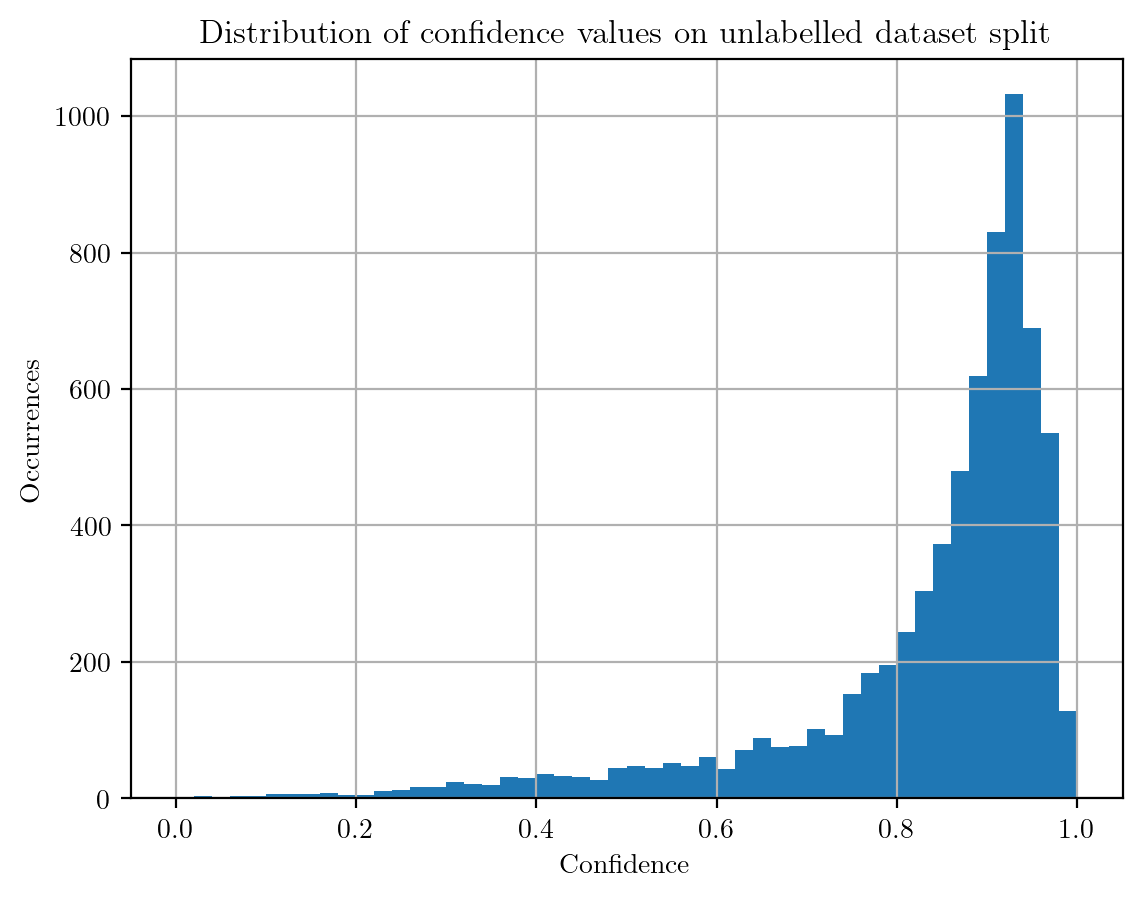

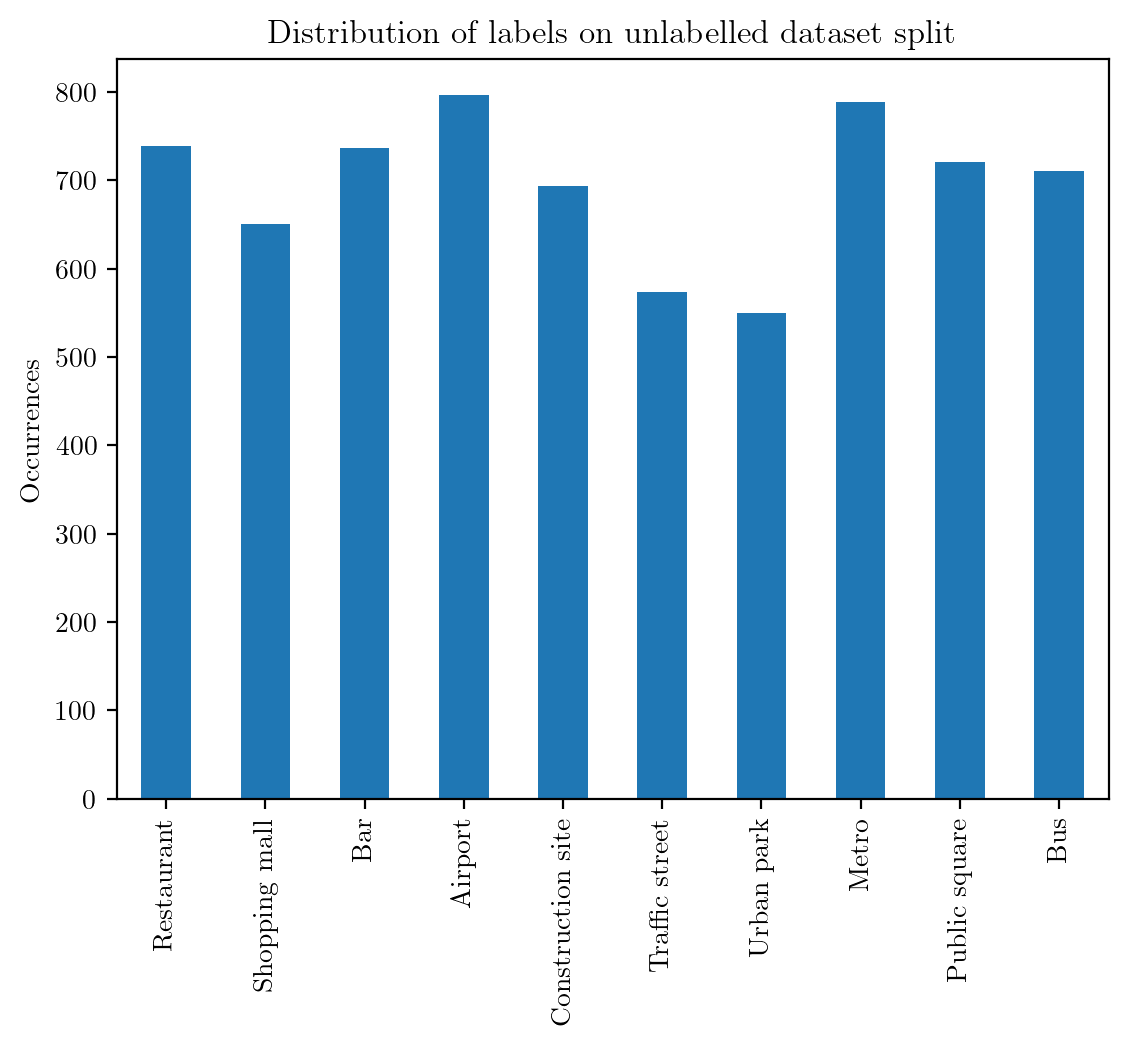

In [8]:
unlabelled_files['confidence'] = (unlabelled_files['confidence'] - unlabelled_files['confidence'].min())/(unlabelled_files['confidence'].max() - unlabelled_files['confidence'].min())
if to_plot:
    plt.figure()
    unlabelled_files.hist(column = "confidence", bins = 50, grid = True)
    plt.ylabel("Occurrences")
    plt.xlabel("Confidence")
    plt.title("Distribution of confidence values on unlabelled dataset split")
    plt.savefig("pdf_confidence.pdf", transparent = True, bbox_inches='tight')


    plt.figure()
    unlabelled_files['scene_label'].value_counts(sort=False).plot(kind='bar')
    plt.title("Distribution of labels on unlabelled dataset split")
    plt.ylabel("Occurrences")
    plt.xlabel("")
    plt.savefig("pdf_labels.pdf", transparent = True, bbox_inches='tight')
    plt.show()

# TRAINING WITH BOTH STRONG AND WEAK LABELS

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\Comlab\anaconda3\envs\deeplearning\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


(8369, 3)
Testing DataLoader 0: 100%|██████████| 3/3 [00:00<00:00,  4.44it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test/acc                    1.0
     test/loss_class       0.006122261751443148
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


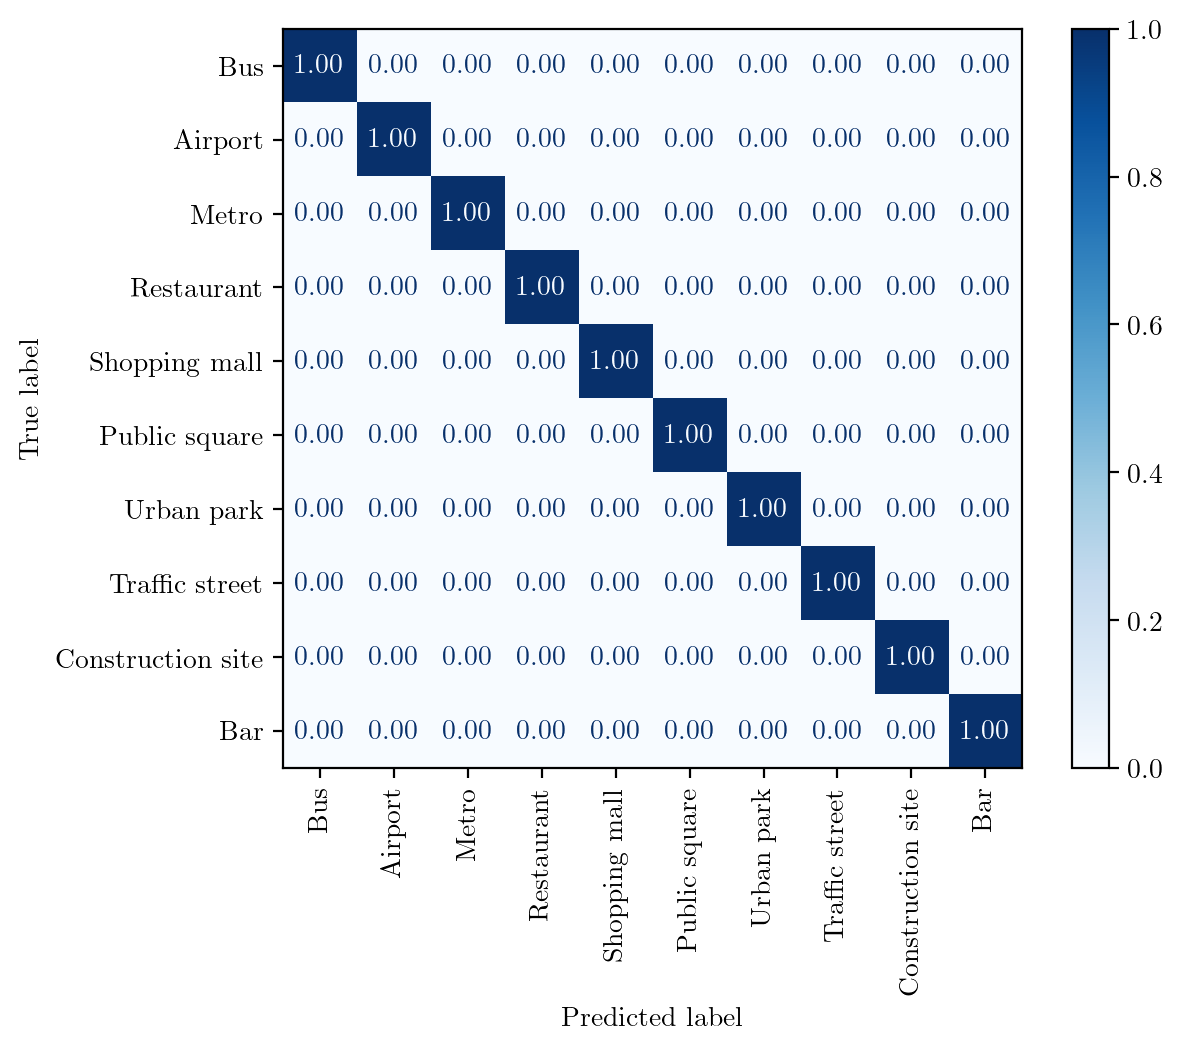

In [9]:
new_trainingSet = pd.concat([trainingSet , unlabelled_files])
print(new_trainingSet.shape)
datamodule = ICME2024Datamodule(new_trainingSet, valSet, testSet, path_audios = path_audios, batch_size = 64)
if is_train:
    model = Wavegram_AttentionMap.load_from_checkpoint("pretrained_GC_hl19.ckpt", lr = 0.001)
    wandb_logger = WandbLogger(project="ICME2024Challenge", name="WavegramAttention m = 0.2 s = 8 no mixup", tags = ["ICMEGCDataset", "allLabels"])
    trainer = Trainer(accelerator="gpu", devices = 1 , max_epochs = 100, logger=wandb_logger)
    model.model.arcface = ArcMarginProduct(in_features = 128, out_features = 10, s = 8, m = 0.2)
    trainer.fit(model, datamodule)
    trainer.test(model, datamodule)
    if to_plot:
        confusion_matrix = model.conf_mat.compute()
        confusion_matrix = confusion_matrix / (torch.sum(confusion_matrix, 1).unsqueeze(1))
        disp = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix.cpu().numpy(), display_labels = LABELS_GC)
        disp.plot(cmap = "Blues", xticks_rotation = "vertical", values_format = '.2f')
        plt.savefig("CF_final.pdf", transparent = True, bbox_inches='tight')
    wandb.finish()
else:
    model = Wavegram_AttentionMap.load_from_checkpoint("pretrained_GC_final_o2c4.ckpt", lr = 0.001)
    trainer = Trainer(accelerator="gpu", devices = 1 , max_epochs = 100)
    trainer.test(model, datamodule)
    if to_plot:
        confusion_matrix = model.conf_mat.compute()
        confusion_matrix = confusion_matrix / (torch.sum(confusion_matrix, 1).unsqueeze(1))
        disp = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix.cpu().numpy(), display_labels = LABELS_GC)
        disp.plot(cmap = "Blues", xticks_rotation = "vertical", values_format = '.2f')
        plt.savefig("CF_final.pdf", transparent = True, bbox_inches='tight')

Example of mel spec and wavegram from final model

In [10]:
if to_plot:
    model = Wavegram_AttentionMap.load_from_checkpoint(checkpoint_path = "pretrained_GC_final_o2c4.ckpt", lr = 0.001)
    model = model.eval()
    index = np.random.randint(low = 0, high = testSet.shape[0])
    with torch.no_grad():
        filename = testSet.iloc[index, 0] + ".wav"
        print(filename)
        audio, sr = lb.load(join(path_audios, filename), mono = True, sr = 16000)
        audio = torch.tensor(audio, dtype = torch.float, device = model.device).unsqueeze(0)
        # print(audio.shape)
        predicted, reppr, _, heatmap = model(audio, None)
        print(predicted)
        confidence = torch.softmax(predicted, 1)
        print(confidence)
        label_int = torch.argmax(confidence, 1).squeeze().cpu().numpy()
        print(label_int)
        string_label = LABELS_GC[label_int]
        print(string_label)
        confidence = confidence.cpu().squeeze().numpy()
        single_confidence = confidence[label_int]
        print(single_confidence)


    reppr = reppr.squeeze().cpu().numpy()
    heatmap = heatmap.squeeze().cpu().numpy()
    time_steps = np.linspace(0, 10, reppr[0].shape[1])

    fig, axs = plt.subplots(2, 2, figsize = (18, 6), sharex = True, sharey = True, dpi = 800)

    im = axs[0, 0].imshow(reppr[0], aspect='auto', origin='lower', 
            extent=[time_steps.min(), time_steps.max(), 0, reppr[0].shape[0]], cmap=plt.get_cmap("magma"))
    cbr = plt.colorbar(im, ax = axs[0, 0])
    axs[0, 0].set_title('log-Mel Spectrogram')
    im = axs[0, 1].imshow(reppr[1], aspect='auto', origin='lower', 
            extent=[time_steps.min(), time_steps.max(),  0, reppr[0].shape[0]], cmap=plt.get_cmap("magma"))
    cbr = plt.colorbar(im, ax = axs[0, 1])
    axs[0, 1].set_title('Wavegram')
    im = axs[1, 0].imshow(heatmap[0], aspect='auto', origin='lower', 
            extent=[time_steps.min(), time_steps.max(),  0, reppr[0].shape[0]], vmin = 0, vmax = 1, cmap=plt.get_cmap("magma"))
    cbr = plt.colorbar(im, ax = axs[1, 0])
    axs[1, 0].set_title('Attention map 0')
    im = axs[1, 1].imshow(heatmap[1], aspect='auto', origin='lower', 
            extent=[time_steps.min(), time_steps.max(),  0, reppr[0].shape[0]], vmin = 0, vmax = 1, cmap=plt.get_cmap("magma"))
    cbr = plt.colorbar(im, ax = axs[1, 1])
    axs[1, 1].set_title('Attention map 1')
    # fig.suptitle("Features of the proposed approach")
    fig.supxlabel('Time [s]')
    # fig.supylabel('Mel bins')
    fig.text(0, 0.5, 'Mel bins', va='center', rotation='vertical')
    plt.tight_layout()
    plt.savefig("features.pdf", transparent = True, bbox_inches='tight')

    IPython.display.Audio(join(path_audios, filename), rate = 16000)

4de6b643f0e04c1e92df582012f89f4f44_1.wav
tensor([[-0.1143, -0.0928, -0.1446, -0.0954, -0.0870, -0.1092, -0.1169, -0.1167,
          0.9980, -0.1145]], device='cuda:0')
tensor([[0.0828, 0.0846, 0.0803, 0.0844, 0.0851, 0.0832, 0.0826, 0.0826, 0.2518,
         0.0828]], device='cuda:0')
8
Construction site
0.25177857


# Creation of CSV file (EVALUATION DATASET)

In [11]:
eval_csv = "ICME2024_ASC_eval.csv"
path_eval = "eval"
evaluation_dataset = pd.read_csv(eval_csv)

model = Wavegram_AttentionMap.load_from_checkpoint(checkpoint_path = "pretrained_GC_final_o2c4.ckpt", lr = 0.001)
model = model.eval()

# unlabelled_files is the variable containing filename , empty label , confidence = 0
with torch.no_grad():
    for i in tqdm(range(evaluation_dataset.shape[0])): # for each file, we fed to the trained model to obtain pseudo labels
        # same process as a __getitem__ of a pytorch Dataset
        filename_raw = evaluation_dataset.iloc[i, 0] 
        filename = filename_raw + ".wav"
        audio, sr = lb.load(join(path_eval, filename), mono = True, sr = 16000)
        audio = torch.tensor(audio, dtype = torch.float, device = model.device).unsqueeze(0)
        predicted, _, _, _ = model(audio, None)
        confidence = torch.softmax(predicted, 1)
        label_int = torch.argmax(confidence, 1).squeeze().cpu().numpy()
        string_label = LABELS_GC[label_int]
        confidence = confidence.cpu().squeeze().numpy()
        single_confidence = confidence[label_int]
        evaluation_dataset.iloc[i, 0] = filename_raw
        evaluation_dataset.iloc[i, 1] = string_label

evaluation_dataset.to_csv("results.csv", index = False) # final csv submission file


  0%|          | 0/1100 [00:00<?, ?it/s]C:\Users\Comlab\AppData\Local\Temp\ipykernel_42476\3479305873.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Metro' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  evaluation_dataset.iloc[i, 1] = string_label
100%|██████████| 1100/1100 [00:14<00:00, 76.04it/s]
